##Uber Fare Prediction Using Random Forest Regression Model:

---


**Project Overview:**

**Objective**: Build and Evaluate Random Forest Regression Models for Uber fare prediction

**Description**:

1. Data Source: uber.csv (The dataset consist cab ride detail each row representing 1 ride)
2. Data Preparation: Preprocess the data, including feature engineering, handling missing values, split the data as needed.
3. Model Building: Implement Random Forest Regression algorithm.
4. Model Evaluation: Evaluate the performance of each model using Mean Absolute Error (MAE), Mean Squared Error (MSE), R-squared.

**Prepared by:** Sumit Nalwade

**Professor:** Stephanie Langeland

**Date:** 12-05-2023

---

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import *

In [2]:
# Here we are importing dataset by using pandas
data = pd.read_csv('/content/uber.csv')

In [3]:
# create a copy
df = data.copy()

In [4]:
df.head(3)

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [6]:
df.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [7]:
# Droping unwanted columns
df = df.drop(['Unnamed: 0', 'key'], axis= 1)

### Exploratory Data Analysis

In [10]:
# Checking data types of columns
df.dtypes

fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [11]:
# Converting 'pickup_datetime' to datetime data type from object
df.pickup_datetime = pd.to_datetime(df.pickup_datetime, errors='coerce')

In [12]:
# Creating new features such as "hour", "day", "month", "day of week", "year"
df= df.assign(hour = df.pickup_datetime.dt.hour,
             day= df.pickup_datetime.dt.day,
             month = df.pickup_datetime.dt.month,
             year = df.pickup_datetime.dt.year,
             dayofweek = df.pickup_datetime.dt.dayofweek)

In [13]:
# Checking null values in our dataset
df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
hour                 0
day                  0
month                0
year                 0
dayofweek            0
dtype: int64

We can see there are only 2 null values in our dataset. We will handle it later in the notebook

##### Here we are going to use Heversine formula to calculate the distance between two points and journey, using the longitude and latitude values.


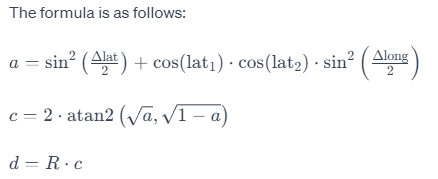



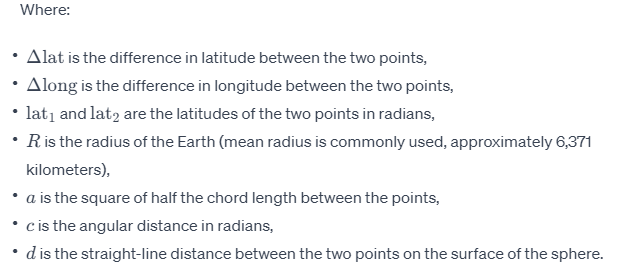

In [14]:
# function to calculate the travel distance from the longitudes and latitudes
def distance_transform(longitude1, latitude1, longitude2, latitude2):
    travel_dist = []

    for pos in range(len(longitude1)):
        long1,lati1,long2,lati2 = map(radians,[longitude1[pos],latitude1[pos],longitude2[pos],latitude2[pos]])
        dist_long = long2 - long1
        dist_lati = lati2 - lati1
        a = sin(dist_lati/2)**2 + cos(lati1) * cos(lati2) * sin(dist_long/2)**2
        c = 2 * asin(sqrt(a))*6371
        travel_dist.append(c)

    return travel_dist

In [15]:
# Creating new column to store total distance value between pickup and dropoff point
df['dist_travel_km'] = distance_transform(df['pickup_longitude'].to_numpy(),
                                                df['pickup_latitude'].to_numpy(),
                                                df['dropoff_longitude'].to_numpy(),
                                                df['dropoff_latitude'].to_numpy()
                                              )

In [16]:
# drop the column 'pickup_daetime'
df = df.drop('pickup_datetime',axis=1)

In [17]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fare_amount,200000.0,11.359955,9.901776,-52.000000,6.000000,8.500000,12.500000,499.000000
pickup_longitude,200000.0,-72.527638,11.437787,-1340.648410,-73.992065,-73.981823,-73.967154,57.418457
pickup_latitude,200000.0,39.935885,7.720539,-74.015515,40.734796,40.752592,40.767158,1644.421482
dropoff_longitude,199999.0,-72.525292,13.117408,-3356.666300,-73.991407,-73.980093,-73.963658,1153.572603
dropoff_latitude,199999.0,39.923890,6.794829,-881.985513,40.733823,40.753042,40.768001,872.697628
passenger_count,200000.0,1.684535,1.385997,0.000000,1.000000,1.000000,2.000000,208.000000
hour,200000.0,13.491335,6.515531,0.000000,9.000000,14.000000,19.000000,23.000000
day,200000.0,15.704670,8.687409,1.000000,8.000000,16.000000,23.000000,31.000000
month,200000.0,6.281795,3.438925,1.000000,3.000000,6.000000,9.000000,12.000000
year,200000.0,2011.742440,1.856397,2009.000000,2010.000000,2012.000000,2013.000000,2015.000000


The above output illustrates the summary statistics of all the numeric variables like mean, median (50%), standard deviation, minimum, and maximum values, along with the first and third quantiles.

Note that the minimum amount is -52 and maximum is 499. Ideally fare amount should not be less that 2.5 dollars, which is the minimum value set for fares. Also the minimum count of passengers is 0, which isn't a practical scenario. We will deal with such values as we progress the case study.

In [18]:
df.columns[df.dtypes == 'object']

Index([], dtype='object')

Importance of detecting an outlier
An outlier is an observation that appears to deviate distinctly from other observations in the data. If the outliers are not removed, the model accuracy may decrease. Let us detect the extreme values in the data.

The following can be considered as outliers in this case study:

Amount < -52
Trips with travel distance less than or equal to 0, and more than 130Kms
Trips where 90< latitude <-90, 180 < longitude < -180
We have seen that there are instances of fare_amount less that 0 as well in the data set, where as the minimum fare for any trip is -52 dollars, hence we will remove such observations. We have already seen that the max fare is 499 in the data set.

In [19]:
df.fare_amount.min()

-52.0

In [20]:
sns.set(rc={'figure.figsize':(5,7.5)})

<Axes: >

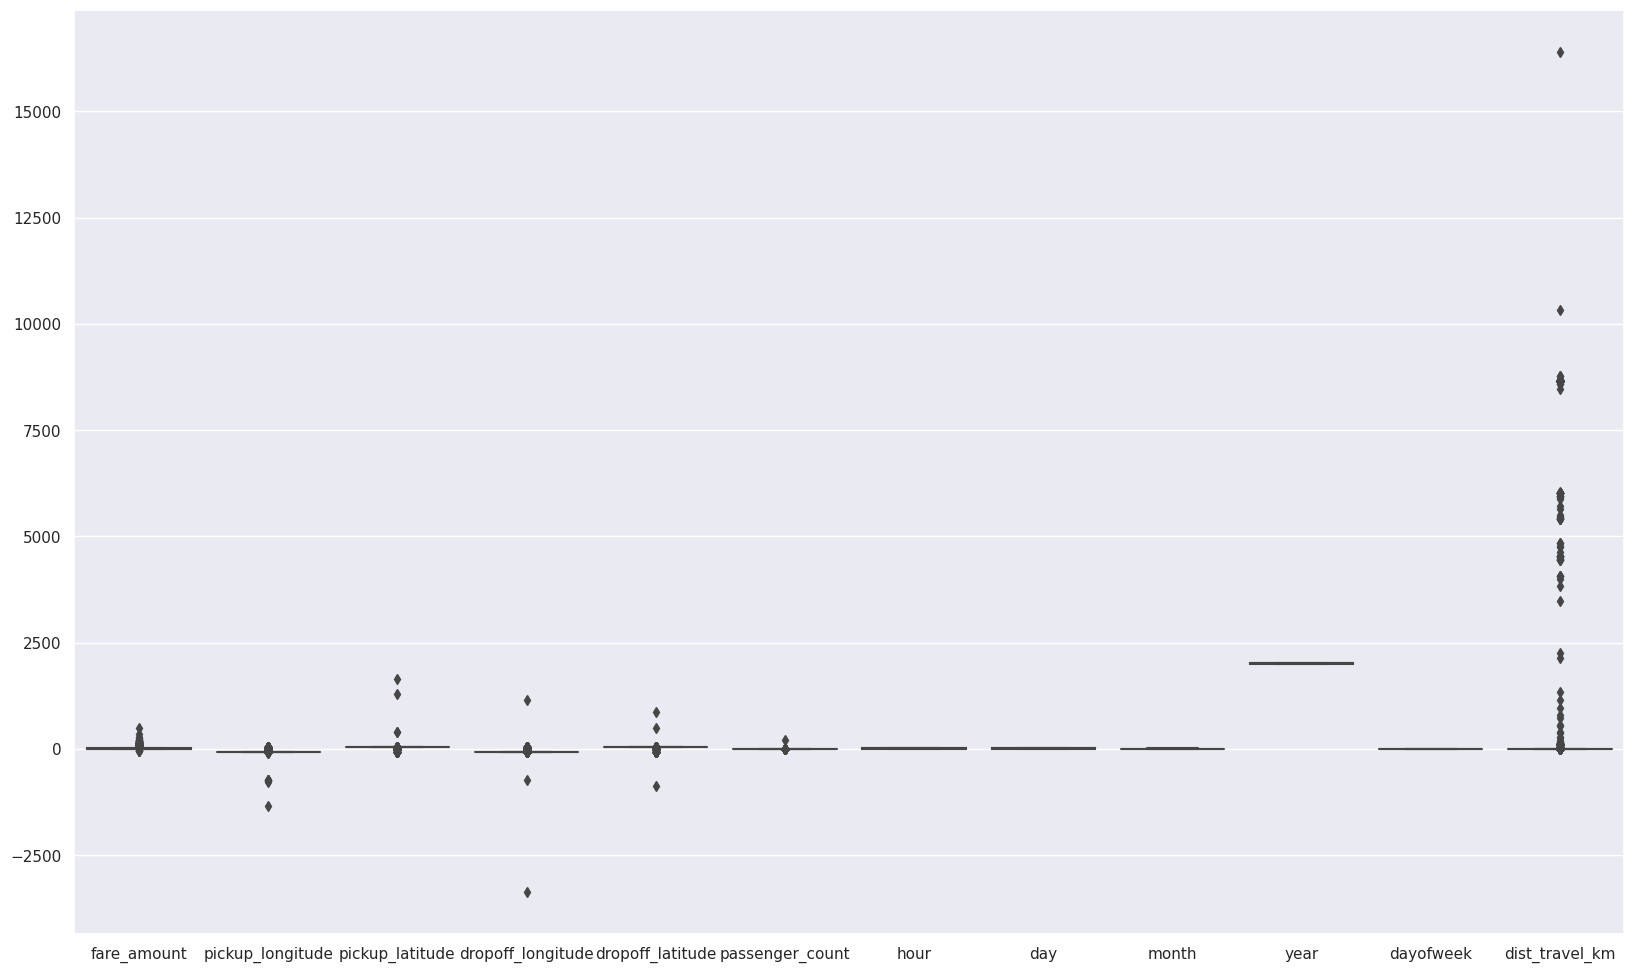

In [21]:
plt.figure(figsize=(20,12))
sns.set(rc={'figure.figsize':(5,5)})
sns.boxplot(data= df)

In [22]:
# lambda function to fill null values with median of a column
medianFiller = lambda x : x.fillna(x.median())
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
df[numeric_columns] = df[numeric_columns].apply(medianFiller, axis = 0)

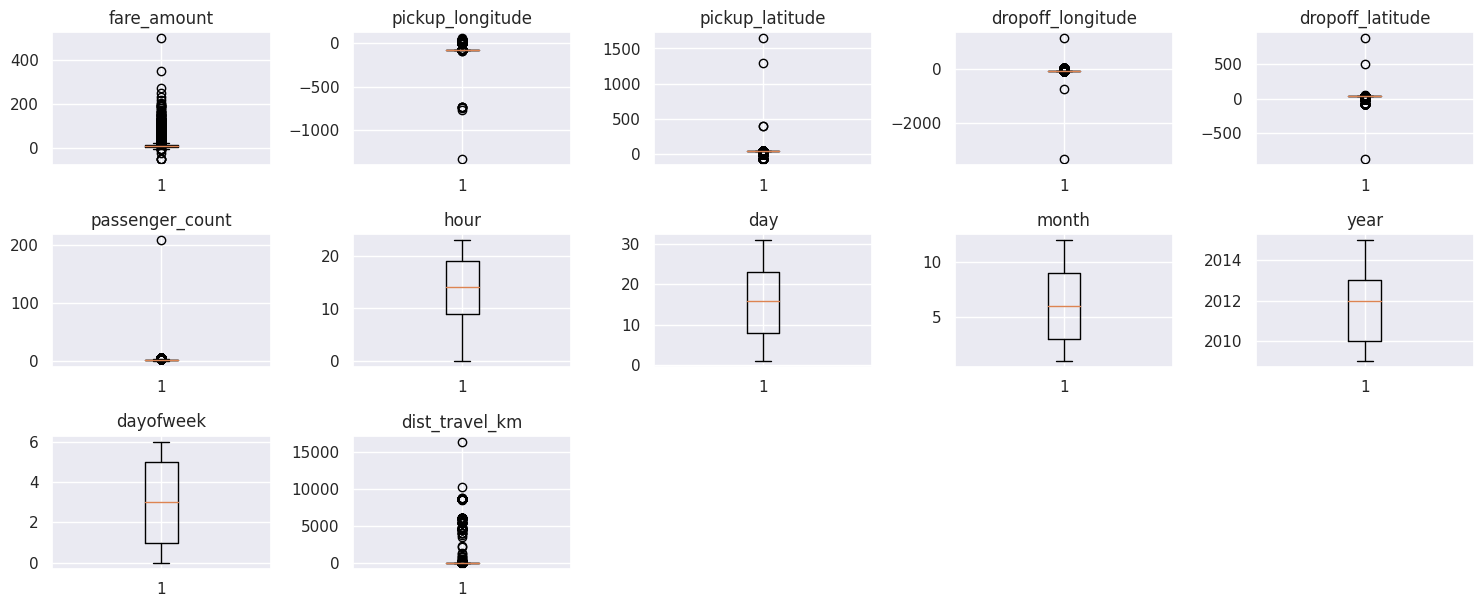

In [25]:
# outliers detection using boxplot
plt.figure(figsize =(15, 12))

for i , variable in enumerate(numeric_columns):
    plt.subplot(6 , 5, i +1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

In [26]:
#We will only keep the observation where fare is more than on equal to 2.5
df = df.loc[(df.fare_amount >= 2.5)]

In [27]:
def remove_outlier(df1 , col):
    Q1 = df1[col].quantile(0.25)
    Q3 = df1[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1-1.5*IQR
    upper_whisker = Q3+1.5*IQR
    df[col] = np.clip(df1[col] , lower_whisker , upper_whisker)
    return df1

def treat_outliers_all(df1 , col_list):
    for c in col_list:
        df1 = remove_outlier(df , c)
    return df1

In [28]:
df = treat_outliers_all(df , df.iloc[: , 0::])

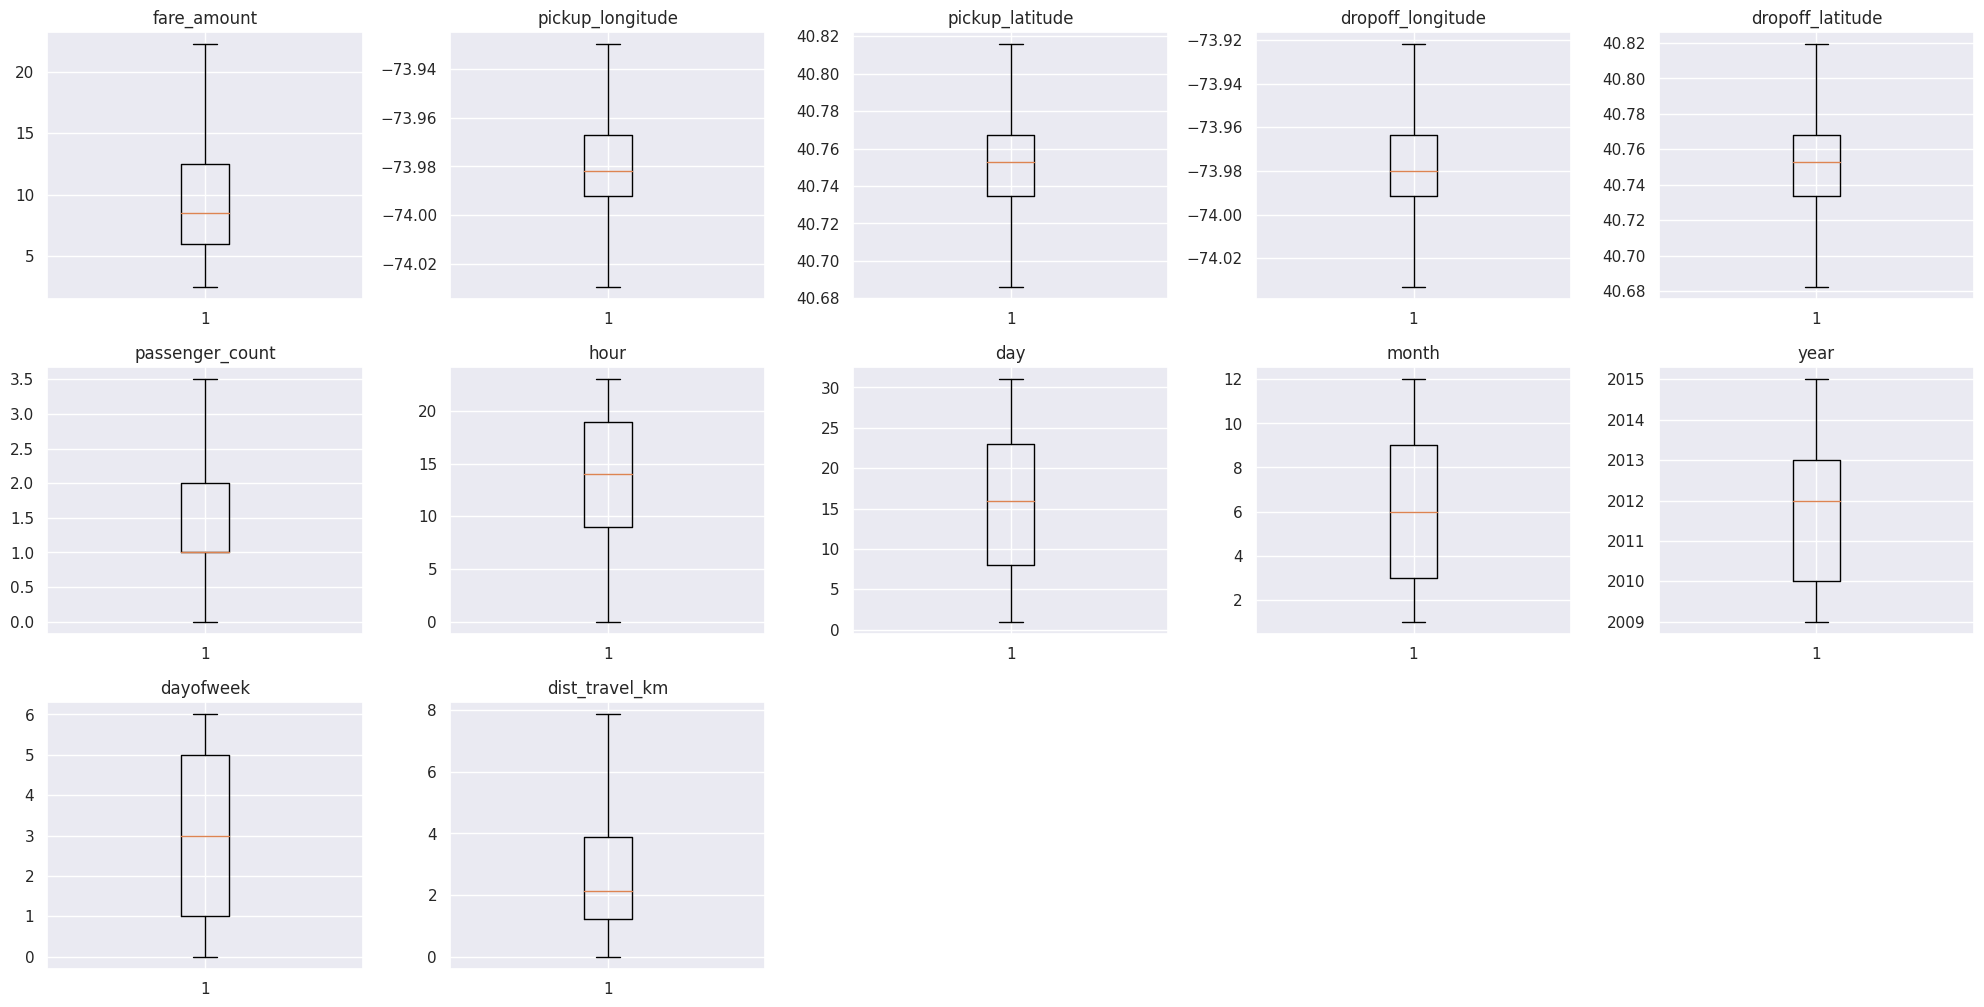

In [29]:
plt.figure(figsize=(20,20))
for i , variable in enumerate(df.iloc[: , 0::]):
    plt.subplot(6,5,i+1)
    plt.boxplot(df[variable] , whis = 1.5)
    plt.tight_layout()
    plt.title(variable)
plt.show()

Remove the observations with travel distance more than 130 kms.As seen from descriptive stats there are obs with travel distance more than 130 km, as that is the limit for trips.

In [30]:
#We will only keep the observation where travel distance is less than or equal to 130
df= df.loc[(df.dist_travel_km >= 1) | (df.dist_travel_km <= 130)]
print("Remaining observastions in the dataset:", df.shape)

Remaining observastions in the dataset: (199975, 12)


Remove the observations with unreal longitude and latitude values , that is , 90< latitude <-90, 180 < longitude < -180

In [31]:
incorrect_coordinates = df.loc[(df.pickup_latitude > 90) |(df.pickup_latitude < -90) |
                                   (df.dropoff_latitude > 90) |(df.dropoff_latitude < -90) |
                                   (df.pickup_longitude > 180) |(df.pickup_longitude < -180) |
                                   (df.dropoff_longitude > 90) |(df.dropoff_longitude < -90)
                                    ]

In [32]:
# Droping incorect cordinates
df.drop(incorrect_coordinates, inplace = True, errors = 'ignore')

In [34]:
Total = df.isnull().sum().sort_values(ascending = False)
Percent = (df.isnull().sum()*100/df.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([Total, Percent], axis = 1, keys = ['Total', 'Percentage of Missing Values'])
missing_data['Type'] = df[missing_data.index].dtypes
missing_data

,Total,Percentage of Missing Values,Type
fare_amount,0,0.0,float64
pickup_longitude,0,0.0,float64
pickup_latitude,0,0.0,float64
dropoff_longitude,0,0.0,float64
dropoff_latitude,0,0.0,float64
passenger_count,0,0.0,float64
hour,0,0.0,int64
day,0,0.0,int64
month,0,0.0,int64
year,0,0.0,int64


In [35]:
# use the corr() function to generate the correlation matrix of the numeric variables
corr = df.corr()

# print the correlation matrix
corr

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek,dist_travel_km
fare_amount,1.000000,0.154181,-0.110890,0.218795,-0.125943,0.015887,-0.023626,0.004440,0.030569,0.141501,0.013631,0.844670
pickup_longitude,0.154181,1.000000,0.259545,0.425591,0.073333,-0.013264,0.011594,-0.003206,0.001210,0.010206,-0.024625,0.098078
pickup_latitude,-0.110890,0.259545,1.000000,0.048859,0.515772,-0.012857,0.029685,-0.001546,0.001568,-0.014264,-0.042319,-0.046839
dropoff_longitude,0.218795,0.425591,0.048859,1.000000,0.245772,-0.009334,-0.046577,-0.004004,0.002434,0.011292,-0.003291,0.186543
dropoff_latitude,-0.125943,0.073333,0.515772,0.245772,1.000000,-0.006260,0.019739,-0.003514,-0.001206,-0.009519,-0.031899,-0.038855
passenger_count,0.015887,-0.013264,-0.012857,-0.009334,-0.006260,1.000000,0.020309,0.002707,0.010408,-0.009748,0.048556,0.009680
hour,-0.023626,0.011594,0.029685,-0.046577,0.019739,0.020309,1.000000,0.004675,-0.003925,0.002148,-0.086919,-0.038311
day,0.004440,-0.003206,-0.001546,-0.004004,-0.003514,0.002707,0.004675,1.000000,-0.017395,-0.012149,0.005623,0.003063
month,0.030569,0.001210,0.001568,0.002434,-0.001206,0.010408,-0.003925,-0.017395,1.000000,-0.115839,-0.008802,0.011622
year,0.141501,0.010206,-0.014264,0.011292,-0.009519,-0.009748,0.002148,-0.012149,-0.115839,1.000000,0.006085,0.024373


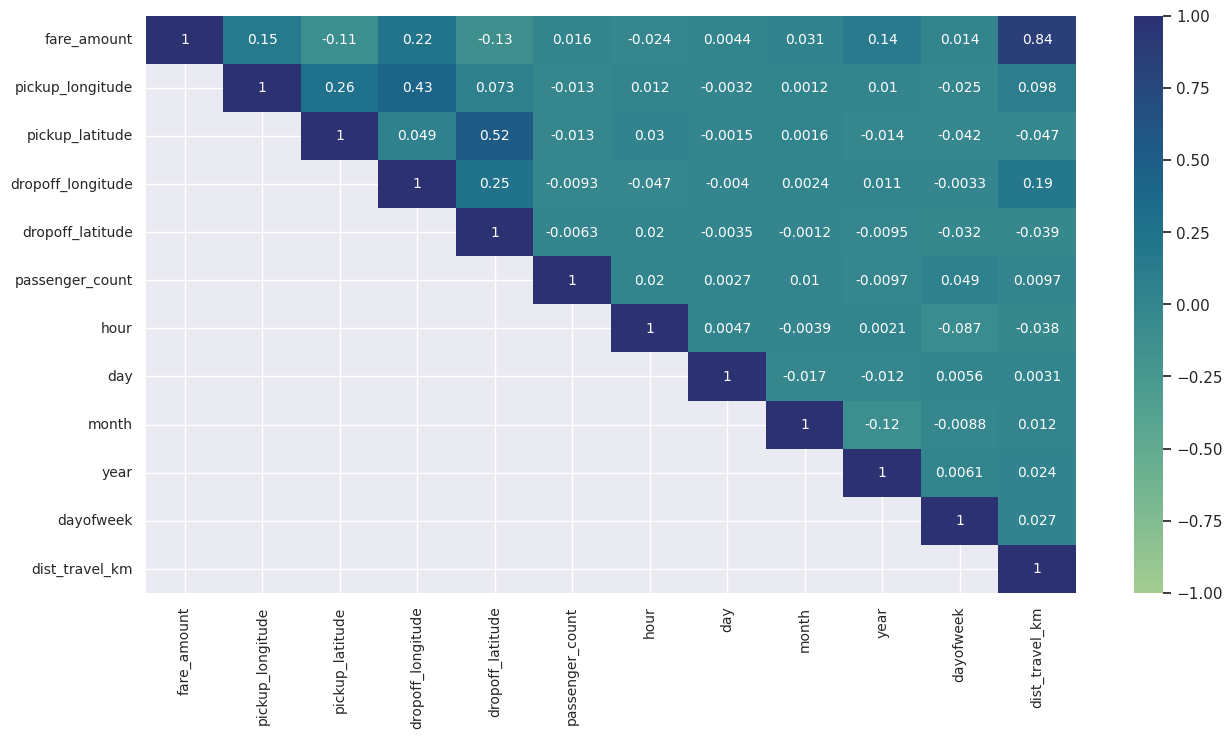

In [36]:
plt.figure(figsize = (15,7.5))

# use 'mask' to plot a upper triangular correlation matrix
# 'tril_indices_from' returns the indices for the lower-triangle of matrix
# 'k = -1' consider the diagonal of the matrix
mask = np.zeros_like(corr)
mask[np.tril_indices_from(mask, k = -1)] = True

# plot the heat map
# corr: give the correlation matrix
# cmap: color code used for plotting
# vmax: gives a maximum range of values for the chart
# vmin: gives a minimum range of values for the chart
# annot: prints the correlation values in the chart
# annot_kws: sets the font size of the annotation
# mask: mask the upper traingular matrix values
sns.heatmap(corr, cmap = 'crest' , vmax = 1.0, vmin = -1.0, annot = True, annot_kws = {"size": 10}, mask = mask)

# set the size of x and y axes labels
# set text size using 'fontsize'
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

# display the plot
plt.show()

*   The heatmap shows that Fare_amount is highly
positive correlated to total distance traveled. Means with increase in traveling distance fare amount will go up.
*   Rest of the features are weekly correlated with the fare amount.



### Data Vizulization


we are going to check the peak hours during weekdays

1.Weekdays

2.Weekends



1. Plot a countplot to check the peak hours during weekdays

<Axes: title={'center': 'Cab trips count during week days'}, xlabel='hour', ylabel='count'>

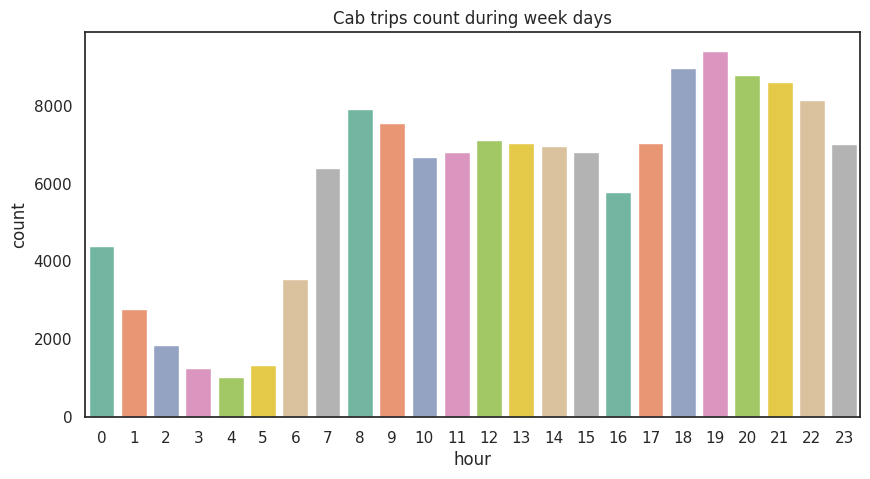

In [39]:
# Set the figure size, grid type and color palette along with appropraite titel for the plot
plt.figure(figsize=(10,5))
plt.title('Cab trips count during week days')
#plot the countplot for weekdays
sns.countplot(x='hour', data=df.loc[(df.dayofweek >= 0) & (df.dayofweek <=4)], palette='Set2')

2. Plot a countplot to check the peak hours during weekends

<Axes: title={'center': 'Cab trips count during week ends'}, xlabel='hour', ylabel='count'>

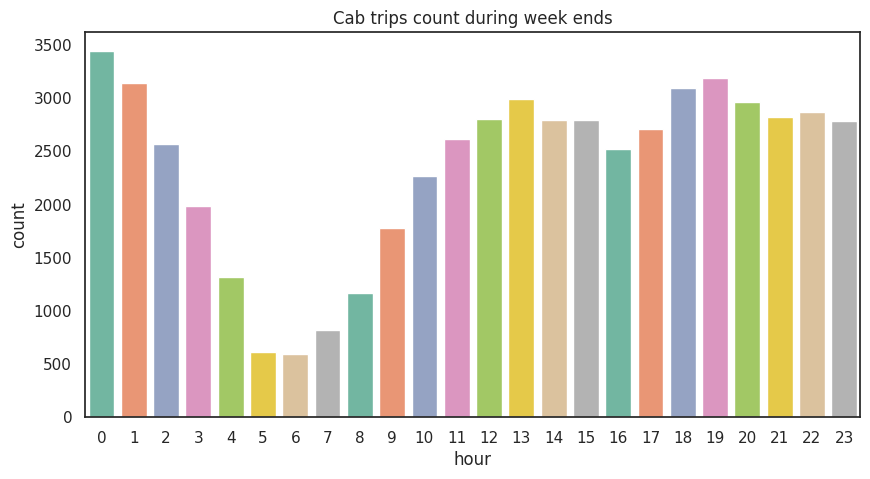

In [40]:
# Set the figure size, grid type and color palette along with appropraite titel for the plot
plt.figure(figsize=(10,5))
plt.title('Cab trips count during week ends')
sns.set_style("white")
#plot the countplot for weekends
sns.countplot(x='hour', data=df.loc[(df.dayofweek >= 5) & (df.dayofweek <=6)], palette='Set2')

**Mean fare for each hour during weekdays and weekends**

In [41]:
# Compute the hourly mean fare for weekdays and weekends
# Set the days in the dataset as week days and week ends
week_days = df.loc[(df.dayofweek >= 0) & (df.dayofweek <= 4)]
week_ends = df.loc[(df.dayofweek >= 5) & (df.dayofweek <= 6)]

# compute the mean fare amount over the week day and week end.
# use groupby('hour') to get the mean fare for each hour
week_days_fare = week_days.groupby(['hour']).fare_amount.mean().to_frame().reset_index()
week_ends_fare = week_ends.groupby(['hour']).fare_amount.mean().to_frame().reset_index()

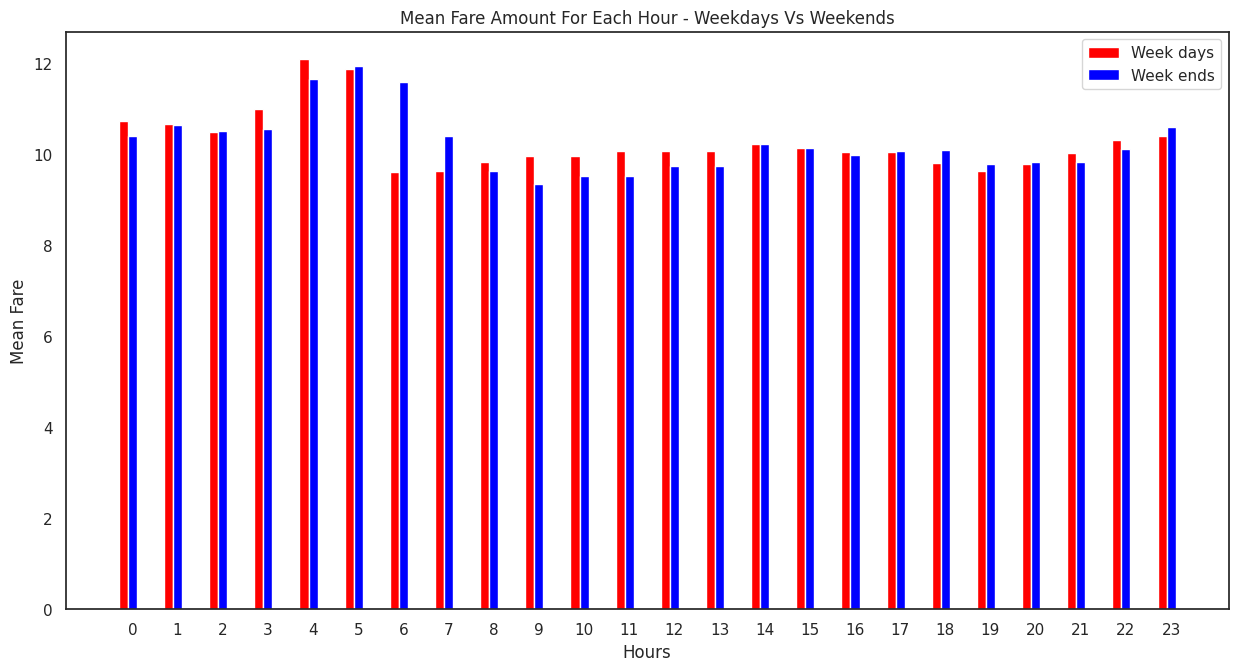

In [42]:
# hours
x = np.array(week_days_fare.hour)
# an array of week day fare
y = np.array(week_days_fare.fare_amount)
# an array of week end fare
z = np.array(week_ends_fare.fare_amount)

# Set the figure size, title, x and y labels
plt.figure(figsize = (15,7.5))
plt.title('Mean Fare Amount For Each Hour - Weekdays Vs Weekends')
plt.xlabel('Hours')
plt.ylabel('Mean Fare')
# Pass the three integers. The value of these integer should be less that 10
ax=plt.subplot(1,1,1)
ax.bar(x-0.2, y, width=0.2, color='red', align='center', label = 'Week days')
ax.bar(x, z, width=0.2, color='blue', align='center', label = 'Week ends')
plt.xticks(range(0,24))
plt.legend()
plt.show()

From the above chart:
1. Mean fare for weekdays is high during office hours (8 am to 12 pm).
2. During Early morning hours (5 am to 7 am) mean fare for weekend is higher than weekday mean fare.

**Distribution of key numerical vairables**

We will check the distribustion of 'travel_dist_km' and 'amount' in our dataset

1. Distribution of "fare_amount"

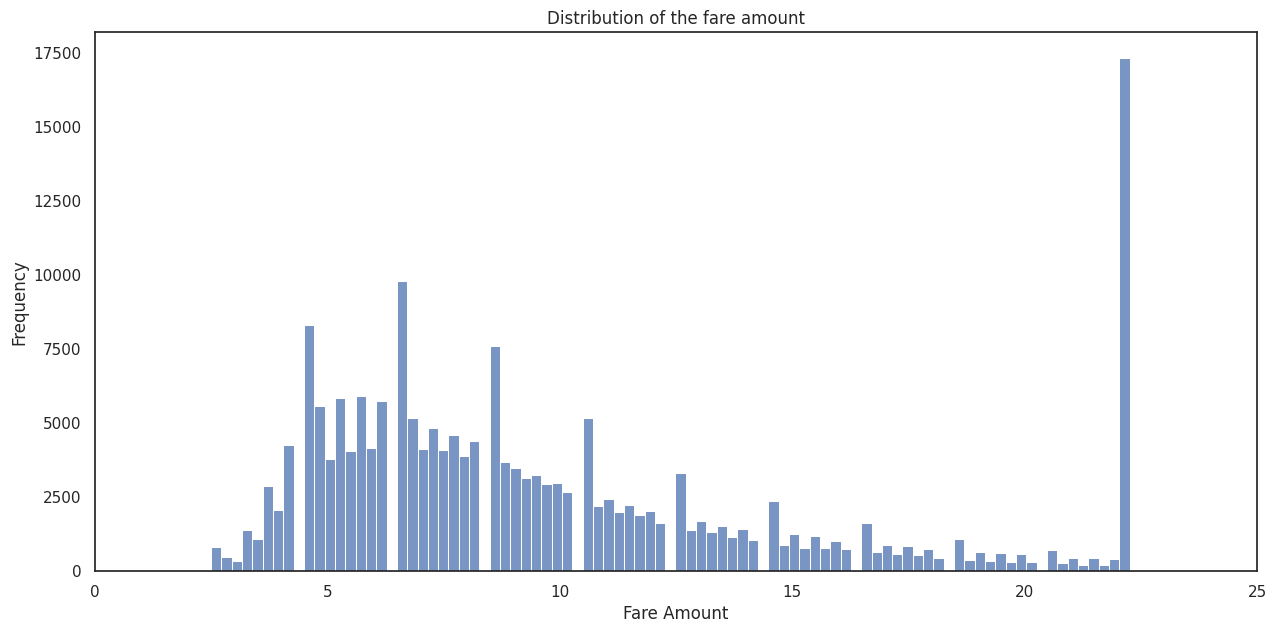

In [50]:
plt.figure(figsize=(15,7))
plt.title("Distribution of the fare amount")
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
plt.xlim(10,20)
plt.xticks(range(0,30,5))


snsplot = sns.histplot(df['fare_amount'])

2. Distribustion of the travel distance in km

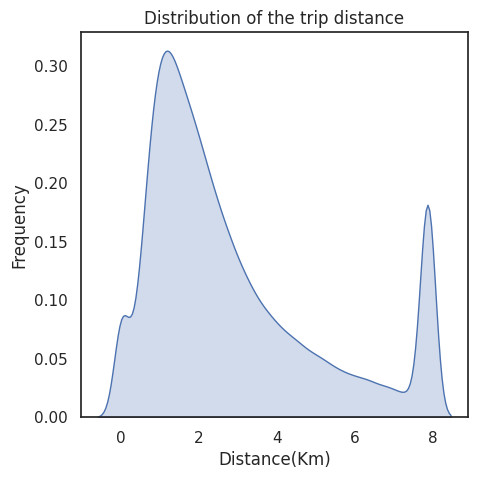

In [60]:
plt.figure(figsize = (5,5))
sns.style = ('darkgrid')
plt.title("Distribution of the trip distance")
plt.xlabel("Distance(Km)")
plt.ylabel("Frequency")
#plt.xlim(-10, 200)
plt.xticks(range(0,50,2))

sns.plot = sns.kdeplot(df[df.dist_travel_km<600].dist_travel_km, fill=True)

**Observations from above 2 charts**

*   Fare amount for cab rides are range from 5$ to 24$ with a highest frequency at 22.25
*   Most cab rides traveled distance is around 2 Km and then 8 km.



#### Random Forest Regression Model

1. Split the data into features and target dataframes

In [62]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek,dist_travel_km
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1.0,19,7,5,2015,3,1.683323
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1.0,20,17,7,2009,4,2.457590
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1.0,21,24,8,2009,0,5.036377
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3.0,8,26,6,2009,4,1.661683
4,16.0,-73.929789,40.744085,-73.973082,40.761247,3.5,17,28,8,2014,3,4.475450


In [63]:
df.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'hour',
       'day', 'month', 'year', 'dayofweek', 'dist_travel_km'],
      dtype='object')

In [64]:
# splitting data into Feature 'x' & Target 'y'
x = df.drop(['fare_amount'], axis =1)
y = df['fare_amount']

In [65]:
x.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek,dist_travel_km
0,-73.999817,40.738354,-73.999512,40.723217,1.0,19,7,5,2015,3,1.683323
1,-73.994355,40.728225,-73.994710,40.750325,1.0,20,17,7,2009,4,2.457590
2,-74.005043,40.740770,-73.962565,40.772647,1.0,21,24,8,2009,0,5.036377
3,-73.976124,40.790844,-73.965316,40.803349,3.0,8,26,6,2009,4,1.661683
4,-73.929789,40.744085,-73.973082,40.761247,3.5,17,28,8,2014,3,4.475450


2. Split the data into training and test sets

In [66]:
# split data into train subset and test subset for predictor and target variables
# 'test_size' returns the proportion of data to be included in the test set
# set 'random_state' to generate the same dataset each time you run the code
from sklearn.model_selection import train_test_split
from sklearn import metrics

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 35)

# check the dimensions of the train & test subset for
# print dimension of predictors train set
print("The shape of X_train is:",x_train.shape)

# print dimension of predictors test set
print("The shape of X_test is:",x_test.shape)

# print dimension of target train set
print("The shape of y_train is:",y_train.shape)

# print dimension of target test set
print("The shape of y_test is:",y_test.shape)

The shape of X_train is: (159980, 11)
The shape of X_test is: (39995, 11)
The shape of y_train is: (159980,)
The shape of y_test is: (39995,)


In [67]:
# import library for random forest regressor
from sklearn.ensemble import RandomForestRegressor

In [68]:
#intantiate the regressor
rf_reg = RandomForestRegressor(n_estimators=100)

# fit the regressor with training dataset
rf_reg.fit(x_train, y_train)

RandomForestRegressor()

In [69]:
# predict the values on test dataset using predict()
y_pred_RF = rf_reg.predict(x_test)

In [71]:
# Taking 10 observation from both testing set and predicted set
actual_values = y_test[0:10]
predicted_values = y_pred_RF[0:10]

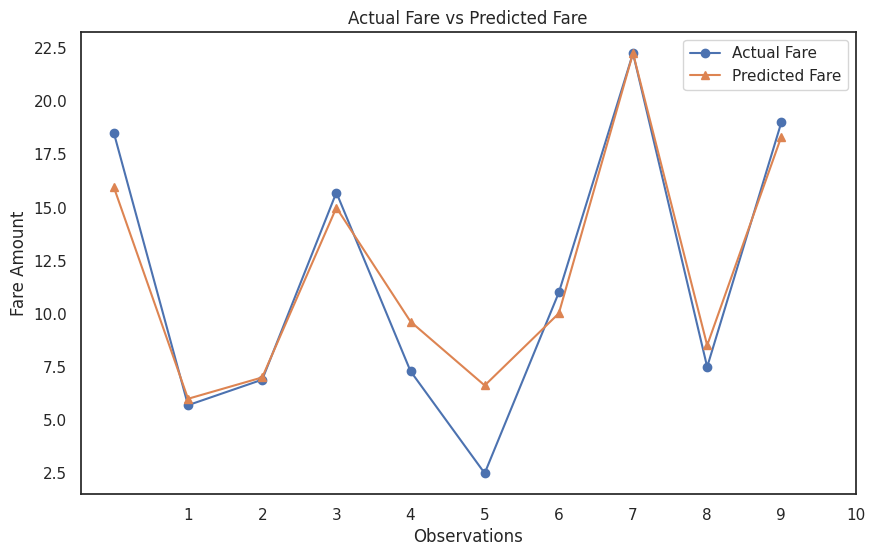

In [72]:
plt.figure(figsize=(10, 6))

plt.plot(actual_values.array, label='Actual Fare', marker='o')
plt.plot(predicted_values, label='Predicted Fare', marker='^')

plt.title('Actual Fare vs Predicted Fare')
plt.xlabel('Observations')
plt.xticks(range(1,11))
plt.ylabel('Fare Amount')
plt.legend()
plt.show()

In [83]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Mean Absolute Error (MAE) for test values and predicted values
mae = mean_absolute_error(y_test, y_pred_RF)

print("Mean Absolute Error:", mae)

# Mean Squared Error (MSE) for test values and predicted values
mse = mean_squared_error(y_test, y_pred_RF)

print("Mean Squared Error:", mse)

# R-squared (R²) for test values and predicted values
r2 = r2_score(y_test, y_pred_RF)*100
print("R-squared: ",r2)


Mean Absolute Error: 1.4791765254883051
Mean Squared Error: 5.486053826029227
R-squared:  81.44401191489388


**Conclusion**

Our model performing well in prediction of uber fare amount with a MSE of 1.5 and R- Squared of 82%. we can further hypertune the model to increase the accuracy.